### Downloading the data

In [56]:
from main import main
key = '<replace with your key>' # this is the key for the weather data API

In [57]:
# uncomment this line on your own risk
# it will take ~15-20 minutes to download the data and to do some cleaning
#main(key)

In [58]:
from configs import merged_cycle_data_file
import pandas as pd
from sklearn.model_selection import train_test_split

### Load the weather & holiday data

In [59]:
from configs import weather_data_csv

holidays = 'holidays.csv'
hol_df = pd.read_csv(holidays, index_col='date', parse_dates=['date'])
weather_df = pd.read_csv(weather_data_csv, index_col='timestamp', parse_dates=['timestamp'])
weather_df.head()

,temperature,feelsLike,wind,weatherCode
timestamp,,,,
2015-01-01 00:00:00,3,-2,21,116
2015-01-01 01:00:00,3,-2,21,116
2015-01-01 02:00:00,3,-1,20,116
2015-01-01 03:00:00,3,-1,20,116
2015-01-01 04:00:00,4,0,20,116


In [60]:
# get a set of the holiday dates
hol_set= set(hol_df.index.map(lambda x: x.date()))

### Load the merged csv file by reading it in chunks

# Warning:
The next cell takes a lot of time (on one machine it took 3h 40 mins) so skip running this cell.

In [61]:
# %%time
# from datetime import datetime
# import time
# chunk_size = 1000000
# date_mapper = lambda x: pd.to_datetime(datetime(year=x.year, month=x.month, day=x.day, hour=x.hour))

# bike_share_df = pd.DataFrame()
# print('Started loading merged_cycle_data_file.')
# iter_ = pd.read_csv(merged_cycle_data_file, chunksize=chunk_size, iterator=True,
#         index_col='Rental Id',
#         parse_dates=['End Date', 'Start Date'])
# print('Finished loading merged_cycle_data_file.')

# r_start = time.time()
# for i, df in enumerate(iter_):
#     r_end = time.time()
#     print(f'{i+1}. Read rows {chunk_size*i}:{chunk_size*(i+1)} in {r_end-r.start:.3f}. ', end='')

#     start = time.time()
#     df = df.dropna()
#     # leave only entries that have valid duration
#     df = df[df['Duration'] > 0]
    
#     diff = df['End Date'] - df['Start Date'] # compute the difference between the objects
#     seconds = diff.map(lambda x: x.total_seconds()) # map to seconds
#     df = df[(df['Duration'] == seconds) & (seconds >= 0)] # check if duration matches the result and if the result is positive
    
    
#     # keep only year, month, day, hour information from the start date
#     df['Start Date'] = df['Start Date'].map(date_mapper)
    
#     share_df = df.groupby('Start Date').agg({'Start Date': 'count'}).rename(columns={'Start Date': 'share_count'})
#     share_df = share_df.join(weather_df)
#     share_df = share_df.reset_index()
#     share_df = share_df.dropna()
    
#     share_df['month'] = share_df['Start Date'].apply(lambda t: t.month)
#     share_df['weekday'] = share_df['Start Date'].apply(lambda t: t.weekday())
#     share_df['hour'] = share_df['Start Date'].apply(lambda t: t.hour)
#     share_df['is_holiday'] = share_df['Start Date'].map(lambda x: x.date() in hol_set).map(lambda x: '1' if x else '0')
#     # check if start date hits on a weekend
#     # monday is 0, sunday is 6
#     share_df['is_weekend'] = share_df['Start Date'].map(lambda x: x.weekday() > 4).map(lambda x: '1' if x else '0')
#     share_df['weatherCode'] = share_df['weatherCode'].map(lambda x: str(int(x)))
    
#     bike_share_df = bike_share_df.append(share_df)
#     end = time.time()
#     print(f'Completed cleaning & merging in {end-start:3.3f} seconds.')
#     r_start = time.time()

# print('Finished reading!')
# bike_share_df = bike_share_df.reset_index().drop(columns=['index']) # fix the index
# # save the data to a file, so that we can load it faster next time
# bike_share_df.to_csv('shares-ungrouped.csv')

In [62]:
types = {
    'weatherCode': str,
    'is_holiday': str,
    'is_weekend': str
}
bike_share_df = pd.read_csv('shares-ungrouped.csv', parse_dates=['Start Date'], dtype=types).drop(columns=['Unnamed: 0'])

In [63]:
bike_share_df.shape

(42768, 11)

In [64]:
bike_share_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42768 entries, 0 to 42767
Data columns (total 11 columns):
Start Date     42768 non-null datetime64[ns]
share_count    42768 non-null int64
temperature    42768 non-null float64
feelsLike      42768 non-null float64
wind           42768 non-null float64
weatherCode    42768 non-null object
month          42768 non-null int64
weekday        42768 non-null int64
hour           42768 non-null int64
is_holiday     42768 non-null object
is_weekend     42768 non-null object
dtypes: datetime64[ns](1), float64(3), int64(4), object(3)
memory usage: 3.6+ MB


In [65]:
bike_share_df.head()

,Start Date,share_count,temperature,feelsLike,wind,weatherCode,month,weekday,hour,is_holiday,is_weekend
0,2016-01-02 00:00:00,129,8.0,4.0,36.0,122,1,5,0,0,1
1,2016-01-02 01:00:00,61,8.0,4.0,35.0,122,1,5,1,0,1
2,2016-01-02 02:00:00,35,9.0,5.0,33.0,122,1,5,2,0,1
3,2016-01-02 03:00:00,31,9.0,5.0,32.0,122,1,5,3,0,1
4,2016-01-02 04:00:00,33,9.0,5.0,31.0,122,1,5,4,0,1


In [66]:
bike_share_df.describe()

,share_count,temperature,feelsLike,wind,month,weekday,hour
count,42768.000000,42768.000000,42768.000000,42768.000000,42768.000000,42768.000000,42768.000000
mean,1043.295080,11.784582,10.735269,15.299967,6.303545,3.001146,11.507132
std,1077.375388,6.173576,7.558164,7.725489,3.395681,1.997994,6.901252
min,1.000000,-4.000000,-11.000000,0.000000,1.000000,0.000000,0.000000
25%,173.000000,7.000000,5.000000,10.000000,3.000000,1.000000,6.000000
50%,713.000000,12.000000,10.000000,14.000000,6.000000,3.000000,12.000000
75%,1535.000000,16.000000,17.000000,19.000000,9.000000,5.000000,17.000000
max,7820.000000,35.000000,38.000000,65.000000,12.000000,6.000000,23.000000


In [67]:
bike_share_df[bike_share_df['Start Date'] == '2018-01-01 00:00:00']

,Start Date,share_count,temperature,feelsLike,wind,weatherCode,month,weekday,hour,is_holiday,is_weekend
40461,2018-01-01,753,7.0,3.0,26.0,113,1,0,0,1,0


In [68]:
# because of reading in chunks, some hours appear multiple times
bike_share_df[bike_share_df['Start Date'] == '2018-12-07 10:00:00']

,Start Date,share_count,temperature,feelsLike,wind,weatherCode,month,weekday,hour,is_holiday,is_weekend
8115,2018-12-07 10:00:00,996,12.0,10.0,27.0,296,12,4,10,0,0
8959,2018-12-07 10:00:00,292,12.0,10.0,27.0,296,12,4,10,0,0


In [69]:
share_total = bike_share_df.groupby('Start Date').agg({'share_count': 'sum'})
share_row = bike_share_df.groupby('Start Date').agg(lambda x: x.iloc[0])
share_row['share_count'] = share_total['share_count']
bike_share_df = share_row.reset_index()
bike_share_df.to_csv('shares-grouped.csv', index=False)

In [70]:
bike_share_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38757 entries, 0 to 38756
Data columns (total 11 columns):
Start Date     38757 non-null datetime64[ns]
share_count    38757 non-null int64
temperature    38757 non-null float64
feelsLike      38757 non-null float64
wind           38757 non-null float64
weatherCode    38757 non-null object
month          38757 non-null int64
weekday        38757 non-null int64
hour           38757 non-null int64
is_holiday     38757 non-null object
is_weekend     38757 non-null object
dtypes: datetime64[ns](1), float64(3), int64(4), object(3)
memory usage: 3.3+ MB


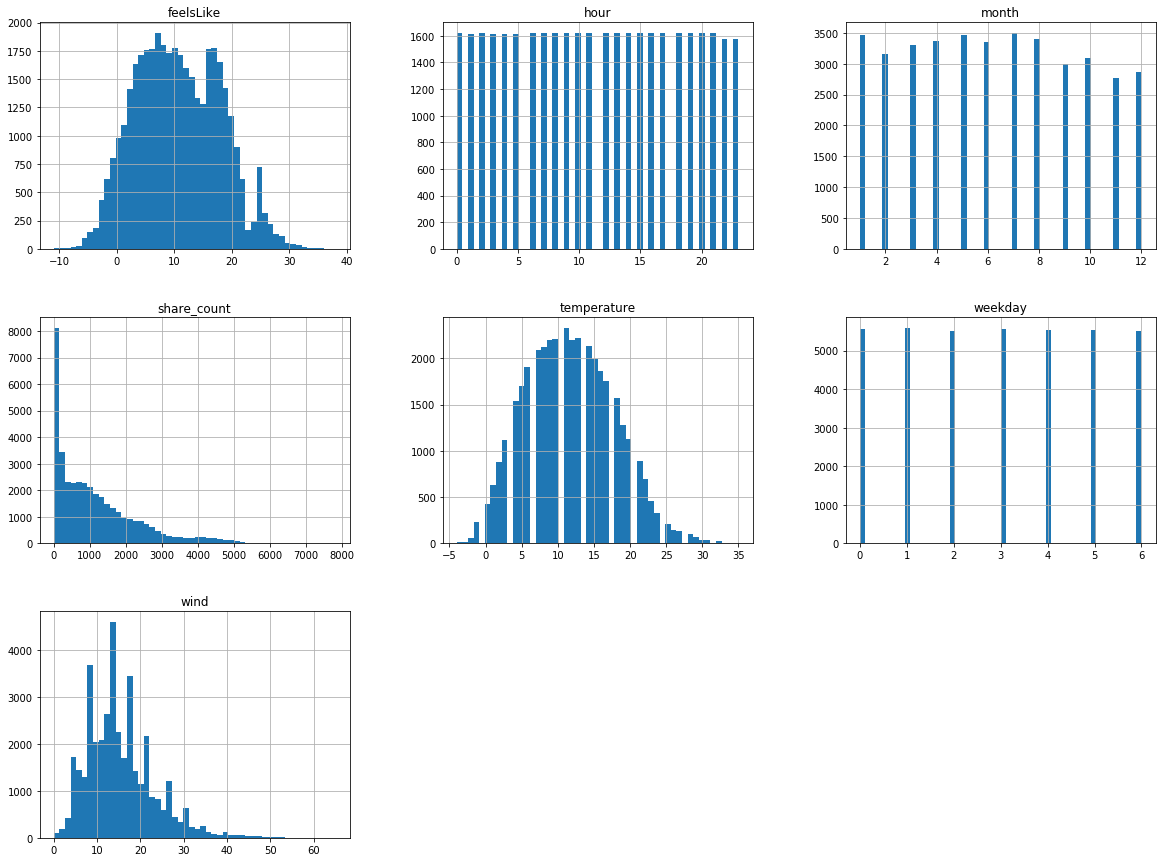

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt
bike_share_df.hist(bins=50, figsize=(20,15))
plt.show()

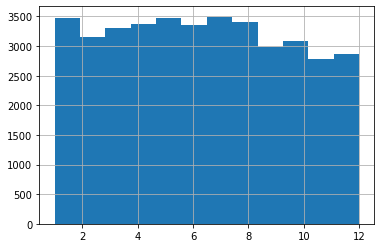

In [72]:
bike_share_df['month'].hist(bins=12)

In [73]:
bike_share_df['weatherCode'].value_counts()

113    10191
116    10159
122     7931
119     4893
176     1393
143     1191
353      730
266      546
296      456
248      319
302      270
200      132
263       84
299       60
317       57
356       48
338       45
332       36
308       35
293       33
389       25
230       24
326       21
371       18
386        9
227        9
329        9
323        6
362        6
320        6
359        6
368        3
305        3
335        3
Name: weatherCode, dtype: int64

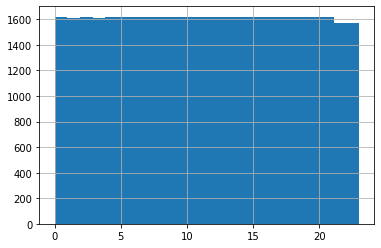

In [74]:
bike_share_df['hour'].hist(bins=24)

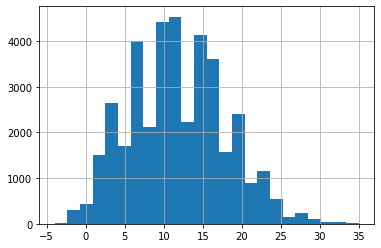

In [75]:
bike_share_df['temperature'].hist(bins=24)

In [76]:
bike_share_df[bike_share_df['share_count'] <= 100].shape

(5563, 11)

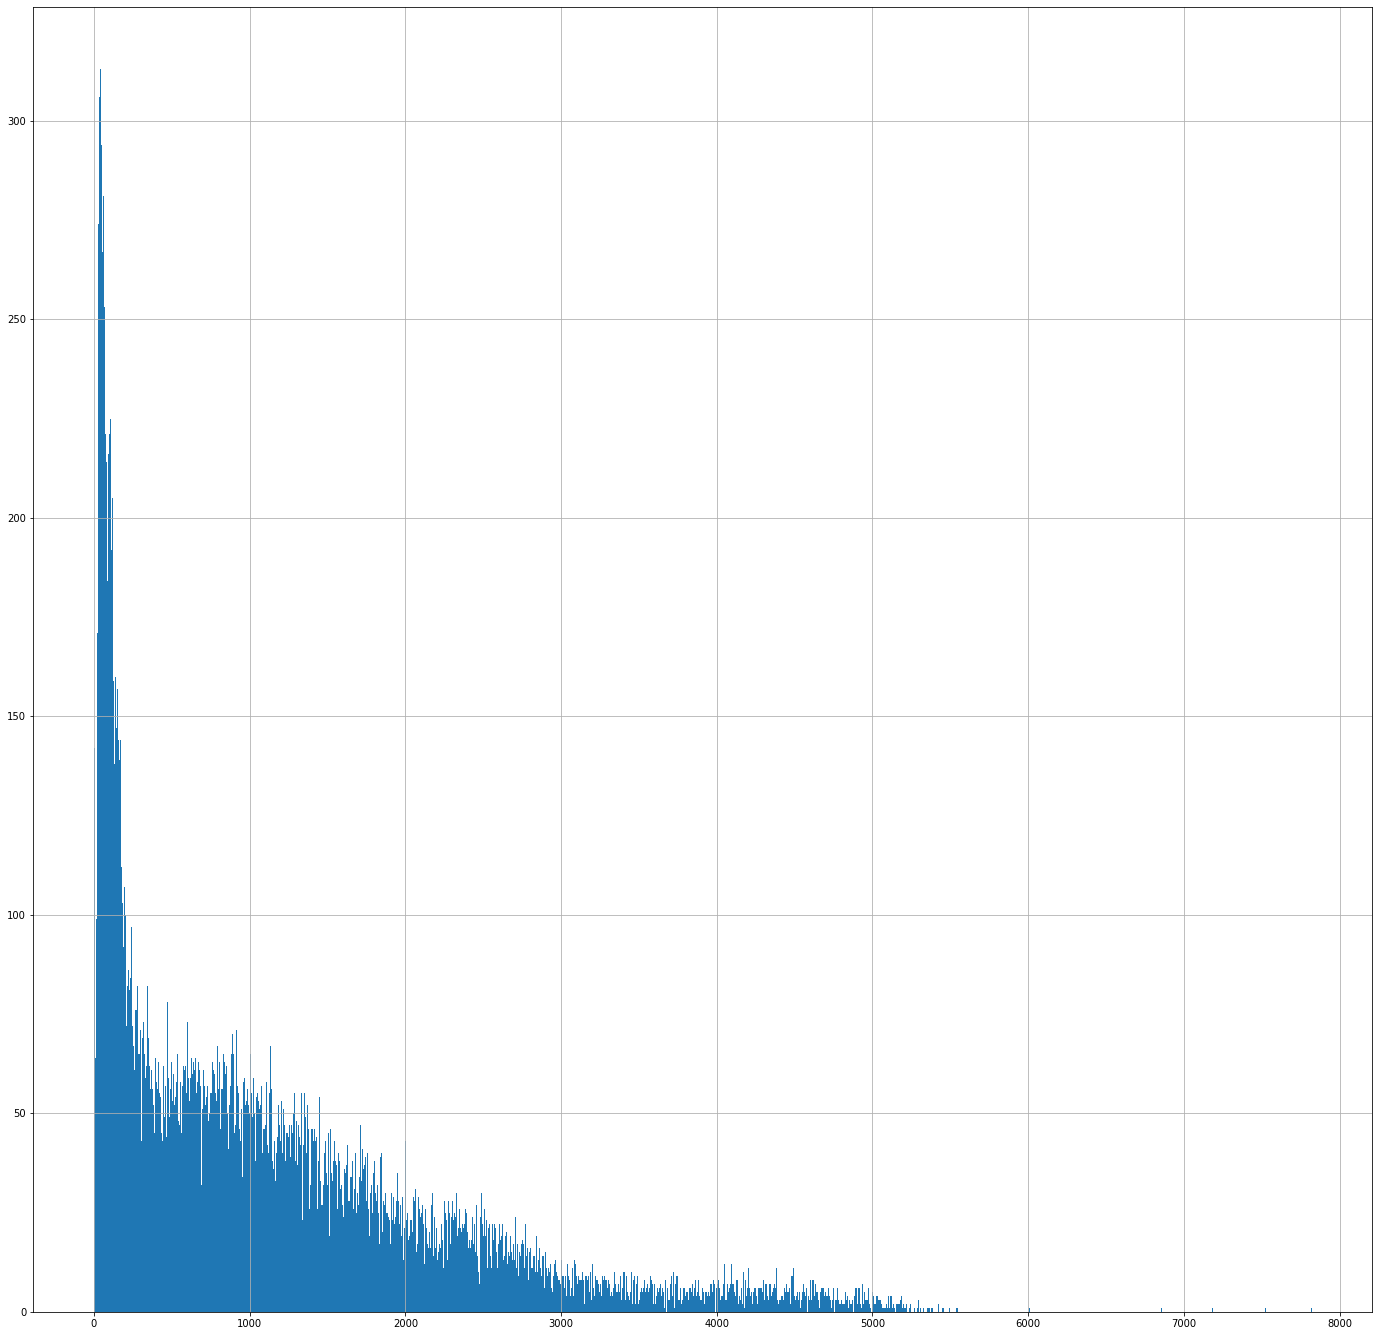

In [77]:
bike_share_df['share_count'].hist(bins=2000, figsize=(24,24))

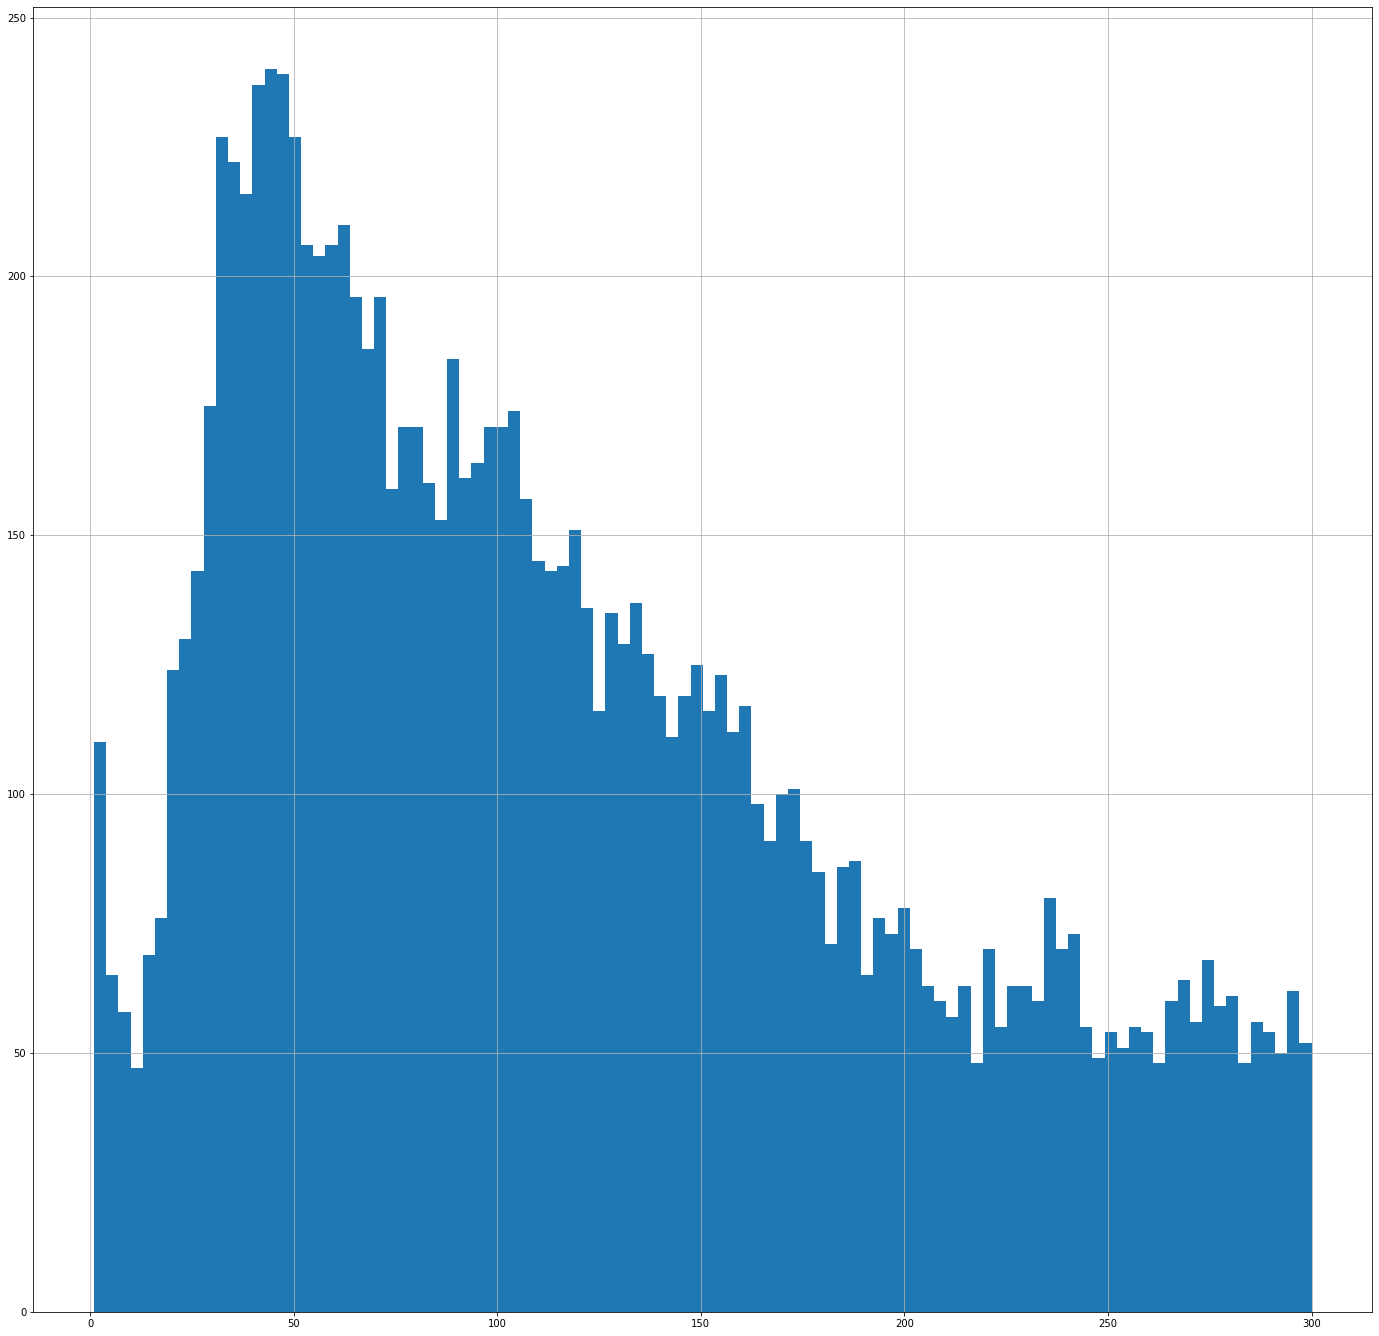

In [78]:
bike_share_df[bike_share_df['share_count'] <= 300]['share_count'].hist(bins=100, figsize=(24,24))

In [83]:
test_df = bike_share_df.copy()

# NEW_CODE: [WEATHER_CODES] (GROUP_NAME)
code_table = {
    1: [113, 113], # ("Clear")
    2: [116, 122, 119], # ("Cloudy")
    3: [266, 263, 176, 353, 296, 293], # ("Light rain")
    4: [302, 299, 256, 308, 359, 305], # ("Heavy rain")
    5: [317, 311, 326, 362, 326, 368], # ("Light snow")
    6: [228, 227, 371, 332, 320, 335, 329], # ("Heavy snow")
    7: [143, 248], # ("Lowered visibility")
    8: [200, 389, 386], # ("Thunder")
    9: [230] # ("Blizzard")
}

def mapWeatherCode(old_weather_code):
    for new_code in code_table:
        if (int(old_weather_code) in code_table[new_code]):
            return str(new_code)

test_df['weatherCode'] = test_df['weatherCode'].map(lambda x: mapWeatherCode(x))

bike_share_df = test_df.copy()

In [85]:
# LabelBinarizer can apply the transformation from text categories
# to integer categories, then from integer categories to one-hot vectors
# basically, it combines a label encoder with one-hot encoder
# from sklearn.preprocessing import LabelBinarizer
# encoder = LabelBinarizer()
# holiday_cat = bike_share_df['weatherCode']
# holiday_cat_1hot = encoder.fit_transform(holiday_cat.to_numpy())
# holiday_cat_1hot

In [86]:
bike_share_df.head()

,Start Date,share_count,temperature,feelsLike,wind,weatherCode,month,weekday,hour,is_holiday,is_weekend
0,2015-01-02 00:00:00,270,10.0,7.0,35.0,2,1,4,0,0,0
1,2015-01-02 01:00:00,244,11.0,7.0,34.0,2,1,4,1,0,0
2,2015-01-02 02:00:00,156,11.0,8.0,32.0,2,1,4,2,0,0
3,2015-01-02 03:00:00,83,11.0,8.0,31.0,2,1,4,3,0,0
4,2015-01-02 04:00:00,59,11.0,8.0,26.0,2,1,4,4,0,0


In [87]:
encoded_weather_codes = pd.get_dummies(bike_share_df['weatherCode'], prefix='weather')
bike_share_df_enc = bike_share_df.drop(['weatherCode'], axis=1)
bike_share_df_enc = bike_share_df_enc.join(encoded_weather_codes)
bike_share_df_enc.head(5)

,Start Date,share_count,temperature,feelsLike,wind,month,weekday,hour,is_holiday,is_weekend,weather_1,weather_2,weather_3,weather_4,weather_5,weather_6,weather_7,weather_8,weather_9
0,2015-01-02 00:00:00,270,10.0,7.0,35.0,1,4,0,0,0,0,1,0,0,0,0,0,0,0
1,2015-01-02 01:00:00,244,11.0,7.0,34.0,1,4,1,0,0,0,1,0,0,0,0,0,0,0
2,2015-01-02 02:00:00,156,11.0,8.0,32.0,1,4,2,0,0,0,1,0,0,0,0,0,0,0
3,2015-01-02 03:00:00,83,11.0,8.0,31.0,1,4,3,0,0,0,1,0,0,0,0,0,0,0
4,2015-01-02 04:00:00,59,11.0,8.0,26.0,1,4,4,0,0,0,1,0,0,0,0,0,0,0


In [88]:
holiday_enc = pd.get_dummies(bike_share_df['is_holiday'], prefix='holiday')
week_enc = pd.get_dummies(bike_share_df['is_weekend'], prefix='weekend')
bike_share_df_enc = bike_share_df_enc.join(holiday_enc).join(week_enc)
bike_share_df_enc = bike_share_df_enc.drop(['is_holiday', 'is_weekend'],axis=1)

In [89]:
# "weekday" could be dropped due to the fact that we have "is_weekend"
# "month" could be dropped due to the fact that the model might not be able to extract any useful information
# out of it
bike_share_df_enc = bike_share_df_enc.drop(['weekday'], axis=1)

In [90]:
import numpy as np

bike_share_df_enc['hr_sin'] = np.sin(bike_share_df_enc.hour*(2.*np.pi/24))
bike_share_df_enc['hr_cos'] = np.cos(bike_share_df_enc.hour*(2.*np.pi/24))
bike_share_df_enc['mnth_sin'] = np.sin((bike_share_df_enc.month-1)*(2.*np.pi/12))
bike_share_df_enc['mnth_cos'] = np.cos((bike_share_df_enc.month-1)*(2.*np.pi/12))
bike_share_df_enc = bike_share_df_enc.drop(['month', 'hour'], axis=1)

In [91]:
bike_share_df_enc.head(5)

,Start Date,share_count,temperature,feelsLike,wind,weather_1,weather_2,weather_3,weather_4,weather_5,...,weather_8,weather_9,holiday_0,holiday_1,weekend_0,weekend_1,hr_sin,hr_cos,mnth_sin,mnth_cos
0,2015-01-02 00:00:00,270,10.0,7.0,35.0,0,1,0,0,0,...,0,0,1,0,1,0,0.000000,1.000000,0.0,1.0
1,2015-01-02 01:00:00,244,11.0,7.0,34.0,0,1,0,0,0,...,0,0,1,0,1,0,0.258819,0.965926,0.0,1.0
2,2015-01-02 02:00:00,156,11.0,8.0,32.0,0,1,0,0,0,...,0,0,1,0,1,0,0.500000,0.866025,0.0,1.0
3,2015-01-02 03:00:00,83,11.0,8.0,31.0,0,1,0,0,0,...,0,0,1,0,1,0,0.707107,0.707107,0.0,1.0
4,2015-01-02 04:00:00,59,11.0,8.0,26.0,0,1,0,0,0,...,0,0,1,0,1,0,0.866025,0.500000,0.0,1.0


In [92]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, SVR
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import Lasso, ElasticNet, Ridge, SGDRegressor

In [93]:
train_set, test_set = train_test_split(bike_share_df_enc.drop('Start Date', axis=1), test_size=0.2, random_state=42069)
X_train = train_set.drop('share_count', axis=1).to_numpy()
Y_train = train_set['share_count'].to_numpy()

X_test = test_set.drop('share_count', axis=1).to_numpy()
Y_test = test_set['share_count'].to_numpy()

In [94]:
random_state = 42069
classifiers = [
#     ('Decision Tree', DecisionTreeClassifier()),
#     ('Random Forest', RandomForestClassifier(n_estimators=100)),
#     ('NN (50, 50, 16)', MLPClassifier(hidden_layer_sizes=(16, 16, 16), verbose=True, learning_rate='adaptive', activation='tanh', learning_rate_init=0.01))
    ('Lasso', Lasso(random_state=random_state)),
    ('ElasticNet', ElasticNet(random_state=random_state)),
    ('Ridge', Ridge(random_state=random_state)),
    ('SVR linear', SVR(kernel='linear', verbose=True)),
    ('SVR rbf', SVR(kernel='rbf', verbose=True)),
    ('SGDRegressor', SGDRegressor()),
    ('GradientBoostRegressor', GradientBoostingRegressor(alpha=0.01))
]

In [95]:
import time
def learn(classifiers, X_train, Y_train, X_test, Y_test):
    for name, clf in classifiers:
        print(f'** {name}')
        t0 = time.time()
        clf.fit(X_train, Y_train)
        t1 = time.time()
        score_train = clf.score(X_train[:10000], Y_train[:10000])
        t2 = time.time()
        score_test = clf.score(X_test, Y_test)
        t3 = time.time()
        print(f'\tTraining time {t1 - t0:3.3f}')
        print(f'\tPrediction time (train) {t2 - t1:3.3f}')
        print(f'\tPrediction time (test) {t3 - t2:3.3f}')
        print(f'\tScore train: {score_train:.3f}\tScore Test: {score_test:.3f}')

In [96]:
learn(classifiers, X_train, Y_train, X_test, Y_test)

** Lasso
	Training time 0.068
	Prediction time (train) 0.010
	Prediction time (test) 0.004
	Score train: 0.362	Score Test: 0.357
** ElasticNet
	Training time 0.102
	Prediction time (train) 0.003
	Prediction time (test) 0.002
	Score train: 0.288	Score Test: 0.277
** Ridge
	Training time 0.015
	Prediction time (train) 0.006
	Prediction time (test) 0.002
	Score train: 0.362	Score Test: 0.358
** SVR linear
[LibSVM]	Training time 48.488
	Prediction time (train) 6.224
	Prediction time (test) 4.777
	Score train: 0.275	Score Test: 0.276
** SVR rbf
[LibSVM]

/home/jakub/.local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


	Training time 61.282
	Prediction time (train) 10.683
	Prediction time (test) 6.970
	Score train: 0.054	Score Test: 0.043
** SGDRegressor


/home/jakub/.local/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


	Training time 4.427
	Prediction time (train) 0.002
	Prediction time (test) 0.001
	Score train: -980.462	Score Test: -691.987
** GradientBoostRegressor
	Training time 2.611
	Prediction time (train) 0.018
	Prediction time (test) 0.014
	Score train: 0.692	Score Test: 0.686


In [ ]:
clf = GradientBoostingRegressor(random_state=random_state)

In [ ]:
clf.fit(X_train, Y_train)

In [ ]:
results = clf.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error

lin_mse = mean_squared_error(Y_test, results)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

In [ ]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(Y_test, results)
lin_mae

In [ ]:
from sklearn.metrics import mean_squared_log_error

nneg_idx = results >= 0

lin_msle = mean_squared_log_error(Y_test[nneg_idx], results[nneg_idx])
lin_rmsle = np.sqrt(lin_msle)
lin_rmsle

In [ ]:
diff = results - Y_test
diff[(diff >= -50) & (diff <= 50)]

In [ ]:
for index, match in enumerate(results < 0):
    if match:
        print(bike_share_df.iloc[index], end='\n\n\n\n\n')
